# Table of Contents
1. [download/read csv file](#sec1)
2. [Convert the labeled data set tags into the new individual tag columns](#sec2)
3. [NLTK](#sec3)
4. [Classifier Building](#sec4)
5. [Frequency Visualizations and Heatmaps](#sec5)
7. [FIS Score](#sec6)

In [6]:
#packages
#%pip install numpy
#%pip install pandas
import numpy as np
import pandas as pd

<a id = "sec1"></a>
## **Download/Read CSV file**

In [7]:
# read csv
github_csv_url = "https://raw.githubusercontent.com/JL72005/PIT-UN-Project4/refs/heads/main/NEW_TAGS_dc_md_va_flash_floods_1996_present.xlsx%20-%20dc_md_va_flash_floods_1996_pres.csv?token=GHSAT0AAAAAADCLZGCRKBOH3I3AIPTZYVF22CDBVOQ"
df = pd.read_csv(github_csv_url)
# print first 5 rows
print(df.head())

   BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  END_YEARMONTH  END_DAY  END_TIME  \
0           199601         19        1100         199601       19      1300   
1           199606         18          30         199606       18       200   
2           199606         20        2200         199606       20      2300   
3           199609          6        1200         199609        6      1800   
4           199611          8        1600         199611        8      1715   

   EPISODE_ID  EVENT_ID                 STATE  STATE_FIPS  ...  END_LOCATION  \
0     2403644   5541358  DISTRICT OF COLUMBIA          11  ...           ALL   
1     1014286   5561204  DISTRICT OF COLUMBIA          11  ...     N PORTION   
2     2040906   5561207  DISTRICT OF COLUMBIA          11  ...     NORTHWEST   
3     2049837   5572405  DISTRICT OF COLUMBIA          11  ...      DOWNTOWN   
4     2049872   5572790  DISTRICT OF COLUMBIA          11  ...      CITYWIDE   

  BEGIN_LAT BEGIN_LON END_LAT  END_LON  \
0 

<a id = "sec2"></a>
## **Convert the labeled data set tags into the new individual tag columns**

In [8]:
#list of tags
tag_names = ['death','injury','evacuation','rescue','car_crash','home_damage','infrastructure_damage','soft_infrastructure_damage','road_closure','power_outage','tree_damage','vehicle_loss','agricultural_damage','campground_damage']
#list of weather events
weather_names = ['nor_easter','thunderstorm','hurricane','tornado','lightning','mudslide']

In [9]:
# Populate columns for OG tags
for tag in tag_names:
    df[tag] = 0  # Initialize column as int
    df.loc[0:906, tag] = df.loc[0:906, 'IMPACT_PREDICTORS'].apply(str).apply(lambda x: 1 if tag in x else 0)

# Populate columns for weather-related tags
for tag in weather_names:
    df[tag] = df['weather_events'].apply(str).apply(lambda x: 1 if tag in x else 0).astype(int)


In [10]:
#check columns
#df[tag_names + weather_names].head(15)
df.loc[300:310, tag_names + weather_names].head(10)

,death,injury,evacuation,rescue,car_crash,home_damage,infrastructure_damage,soft_infrastructure_damage,road_closure,power_outage,tree_damage,vehicle_loss,agricultural_damage,campground_damage,nor_easter,thunderstorm,hurricane,tornado,lightning,mudslide
300,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
301,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
302,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
303,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
304,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
305,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
306,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
307,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
308,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
309,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0


<a id="sec3"></a>
## **NLTK**

In [11]:
#imports
#%pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Tokenization and Stop Word Removal

In [12]:
# TOKENIZATION & REMOVING STOP WRODS

#download necessary NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
#download stopwords
stop_words = set(stopwords.words('english'))

def remove_stopword(text):
  tk = RegexpTokenizer(r'\w+')
  word_tokens = tk.tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  filtered_text = " ".join(filtered_sentence)
  return filtered_text

df['TOKEN_EPISODE_NARRATIVE'] = df['EPISODE_NARRATIVE'].apply(str).apply(remove_stopword)
df['TOKEN_EVENT_NARRATIVE'] = df['EVENT_NARRATIVE'].apply(str).apply(remove_stopword)
df[['TOKEN_EPISODE_NARRATIVE', 'TOKEN_EVENT_NARRATIVE']].head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,TOKEN_EPISODE_NARRATIVE,TOKEN_EVENT_NARRATIVE
0,unusually intense squall line feeding unseason...,nan
1,Intense thunderstorms moved northeast half Was...,nan
2,rapidly developing thunderstorm knocked numero...,nan
3,Feeder bands torrential tropical rains associa...,nan
4,Several roads briefly closed torrential rains ...,nan


### Stemming

In [13]:
# STEMMING

stemmer = PorterStemmer()

def stem_narrative(text):
    token_list = text.split(" ")
    stemmed_list = []
    for word in token_list:
        stemmed_list.append(stemmer.stem(word))
    return stemmed_list

df['STEM_EPISODE_NARRATIVE'] = df['TOKEN_EPISODE_NARRATIVE'].apply(str).apply(stem_narrative).apply(lambda x: " ".join(x)) #where x is the list of stemmed words
df['STEM_EVENT_NARRATIVE'] = df['TOKEN_EVENT_NARRATIVE'].apply(str).apply(stem_narrative).apply(lambda x: " ".join(x)) #where x is the list of stemmed words
df['STEM_EPISODE_NARRATIVE'].head()


0    unusu intens squall line feed unseason warm mo...
1    intens thunderstorm move northeast half washin...
2    rapidli develop thunderstorm knock numer tree ...
3    feeder band torrenti tropic rain associ remnan...
4    sever road briefli close torrenti rain associ ...
Name: STEM_EPISODE_NARRATIVE, dtype: object

### Lemmatization: Reducing word to base form

In [14]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')


# Helper: Convert NLTK POS tag to WordNet POS
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN) 

def lemmatize_narrative(text):
    token_list = text.split(" ")
    lemmatized_list = []
    for word in token_list:
        pos = get_wordnet_pos(word)
        lemmatized_list.append(lemmatizer.lemmatize(word,pos))
    lemmatized_sentence = " ".join(lemmatized_list)
    return lemmatized_sentence.lower()
df= df.fillna('')  # Fill NaN values with empty strings to avoid errors in lemmatization
df['LEM_EPISODE_NARRATIVE'] = df['TOKEN_EPISODE_NARRATIVE'].apply(str).apply(lemmatize_narrative)
df['LEM_EVENT_NARRATIVE'] = df['TOKEN_EVENT_NARRATIVE'].apply(str).apply(lemmatize_narrative)
df["combo_narrative"] = df["LEM_EPISODE_NARRATIVE"].astype(str) + " " + df["LEM_EVENT_NARRATIVE"].astype(str)
df[['LEM_EPISODE_NARRATIVE', 'LEM_EVENT_NARRATIVE']].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


,LEM_EPISODE_NARRATIVE,LEM_EVENT_NARRATIVE
0,unusually intense squall line feed unseasonabl...,nan
1,intense thunderstorm move northeast half washi...,nan
2,rapidly develop thunderstorm knock numerous tr...,nan
3,feeder band torrential tropical rain associate...,nan
4,several road briefly close torrential rain ass...,nan


<a id ="sec4"></a>
## **Classifier Building**

### Corpus Creation

In [15]:
#take spreadsheet of tags and their key words and generate a list/corpus for every tag
import csv
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')


# Helper: Convert NLTK POS tag to WordNet POS
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)  # default to noun

lemmatizer2 = WordNetLemmatizer()
with open('tag_corpus.csv','r') as inputFile:
    data = csv.DictReader(inputFile)
    tag_corpus = {row['Tag']: row['Similar Words'].split(', ') for row in data}
    for tag in tag_corpus:
        for i in range(len(tag_corpus[tag])):
            word = tag_corpus[tag][i].strip()
            pos = get_wordnet_pos(word)
            tag_corpus[tag][i] = lemmatizer.lemmatize(word, pos)
            #print(tag_corpus[tag][i])
        tag_corpus[tag] = list(set(tag_corpus[tag])) #removes duplicates
        print(f"{tag}: {tag_corpus[tag]}")

death: ['swept away', 'drowns', 'casualty', 'death', 'fatal', 'perish', 'lifeless', 'fatality', 'casualities', 'die', 'drown', 'dead']
injury: ['treated and released from Army community hospital', 'wound', 'hurt', 'harm', 'injury', 'injured']
evacuation: ['isolated', 'forced out', 'displace', 'relocate', 'climbed to safety', 'strand', 'evacuate', 'evacuation', 'moved out']
rescue: ['retrieval', 'retrieve', 'save', 'rescue']
car_crash: ['collision', 'car crash', 'wreck', 'accident', 'crash', 'crashed', 'vehicle accident']
home_damage: ['flooded home', 'flooded house', 'property damage', 'shingle', 'basement flooded', 'fence', 'home damage', 'house', 'garage', 'residence damage', 'mobile home parks', 'home destroyed', 'home', 'mobile homes', 'residential gardens', 'roof', 'gutter', 'side', 'mailbox', 'house damage', 'dwelling', 'residence', 'windows,chimneys', 'porch', 'roof collapse', 'apartment buildings', 'shed']
infrastructure_damage: ['mezzanine and platform levels', 'pumping statio

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


### Create Function that adds these tags

In [16]:
def label_tag(text, tag): 
    for syns in tag_corpus[tag]: #the list in the tag 
        if syns in text: #if the text is in the list
            return int(1)
    return int(0)


### Apply The Function to our sets

#### Real Values

In [17]:
# apply the label_tag function to each row in the dataframe for each tag
df2 = df.copy()  # Create a copy of the original dataframe to avoid modifying it directly
for tag in tag_corpus:
    #extract the information from EVENT and EPISODE NARRATIVE columns
    df2["combo_narrative"] = df2["LEM_EPISODE_NARRATIVE"].astype(str) + " " + df2["LEM_EVENT_NARRATIVE"].astype(str)
    df2.loc[0:908, tag] = df2.loc[0:908, "combo_narrative"].apply(lambda text: label_tag(text, tag)).astype(int)
    df2.loc[908:, tag] = df2.loc[908:, "combo_narrative"].apply(lambda text: label_tag(text, tag)).astype(int)


#### Compute the accuracy - Jessica 

In [18]:
for tag in tag_names + weather_names:
    if tag not in df.columns or tag not in df2.columns:
        print(f"Tag: {tag} not found in one of the dataframes, skipping.")
        continue

    match_rate = (df.loc[0:908, tag] == df2.loc[0:908, tag]).mean() * 100 #computing accuracy for only the testing data
    print(f"Tag: {tag}, Accuracy: {match_rate:.2f}%")


Tag: death, Accuracy: 95.93%
Tag: injury, Accuracy: 97.03%
Tag: evacuation, Accuracy: 89.88%
Tag: rescue, Accuracy: 95.93%
Tag: car_crash, Accuracy: 98.79%
Tag: home_damage, Accuracy: 85.26%
Tag: infrastructure_damage, Accuracy: 35.53%
Tag: soft_infrastructure_damage, Accuracy: 89.55%
Tag: road_closure, Accuracy: 87.24%
Tag: power_outage, Accuracy: 86.58%
Tag: tree_damage, Accuracy: 84.16%
Tag: vehicle_loss, Accuracy: 81.63%
Tag: agricultural_damage, Accuracy: 98.90%
Tag: campground_damage, Accuracy: 91.97%
Tag: nor_easter, Accuracy: 100.00%
Tag: thunderstorm, Accuracy: 99.45%
Tag: hurricane, Accuracy: 99.67%
Tag: tornado, Accuracy: 100.00%
Tag: lightning, Accuracy: 97.14%
Tag: mudslide, Accuracy: 96.70%


In [19]:
# viewing thunderstorm tags
thunderstorm_narratives = list(df2[["combo_narrative", "thunderstorm"]].apply(lambda x: x['combo_narrative'] if x['thunderstorm']==1 else "", axis=1))
for i in range(len(thunderstorm_narratives)):
    if not thunderstorm_narratives[i]=="":
        print(i, ": ", thunderstorm_narratives[i],"\n")

1 :  intense thunderstorm move northeast half washington cause road closure low lie area flood notably flood report 16th street n w 0030est bit later south capitol st nan 

2 :  rapidly develop thunderstorm knock numerous tree large limb upper northwest tree fell onto automobile associate torrential rain flood rock creek low lie area northwest portions adjacent parkway close 24 hour follow storm snarl next morning even rush potomac electric power co report 4500 resident district adjacent maryland suburb without power nan 

5 :  tropical moisture feed along south move cold front produce training thunderstorm portion washington metropolitan region late even 25th general 3 4 inch rain fell throughout event least 2 inch fall prior frontal passage around midnight one spotter upper northwest report 4 inch rain prior midnight rapid accumulation water brought rock creek well bank beach drive close late morning 26th nan 

6 :  slow move line thunderstorm dumped 2 4 3 inch rain washington immedi

<a id = "sec5"></a>
## **Visualize the Impacts -Jessica and Emma** 
heatmap, frequency/barchart, co-occurence

In [20]:
import matplotlib.pyplot as plt

### Frequency of Tags in Bar Charts

In [21]:
#FREQUENCY OF TAGS
#testtttt
all_tags = tag_names + weather_names
tag_frequency = []
weather_frequency = []
for i in range(len(tag_names)):
    tag_frequency.append(int(df[tag_names[i]].sum()))
for i in range(len(weather_names)):
    weather_frequency.append(int(df[weather_names[i]].sum()))

Text(0.5, 0, 'Count')

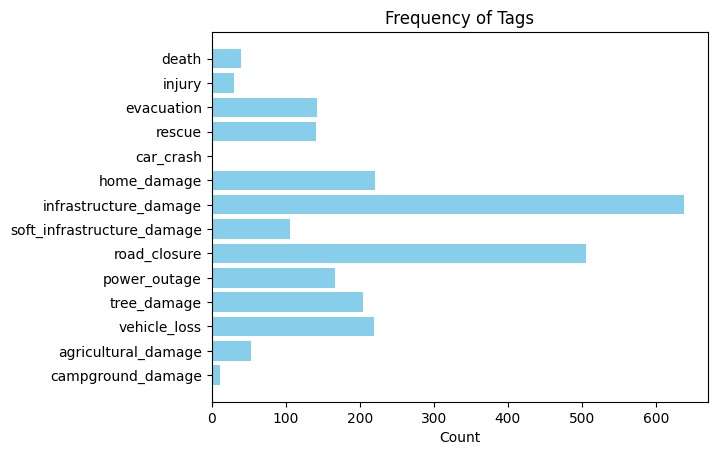

In [22]:
#BAR CHART for frequency of tags
#%pip install matplotlib
import matplotlib.pyplot as plt
tag_names.reverse()
tag_frequency.reverse()
plt.barh(tag_names, tag_frequency, color="skyblue")
plt.title("Frequency of Tags")
plt.xlabel("Count")

Text(0.5, 0, 'Count')

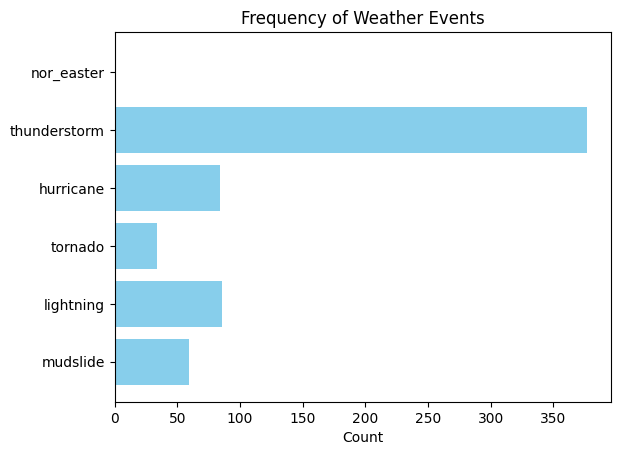

In [23]:
#BAR CHART for frequency of weather events
weather_names.reverse()
weather_frequency.reverse()
plt.barh(weather_names, weather_frequency, color="skyblue")
plt.title("Frequency of Weather Events")
plt.xlabel("Count")

In [24]:
# FREQUENCY PER STATE
def state_label_frequency(state, labels):
    '''Returns a list of the counts of the specific labels for the specific state.
    - state: str
    - labels: list
    '''
    st_frequency = []
    for i in range(len(labels)):
        st_values = list(df[["STATE",labels[i]]].apply(lambda x: x[labels[i]] if str(x["STATE"])==state else 0, axis=1))
        st_frequency.append(sum(st_values))
    return st_frequency

Text(0.5, 0, 'Count')

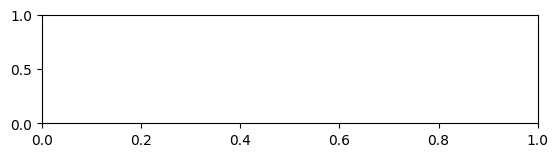

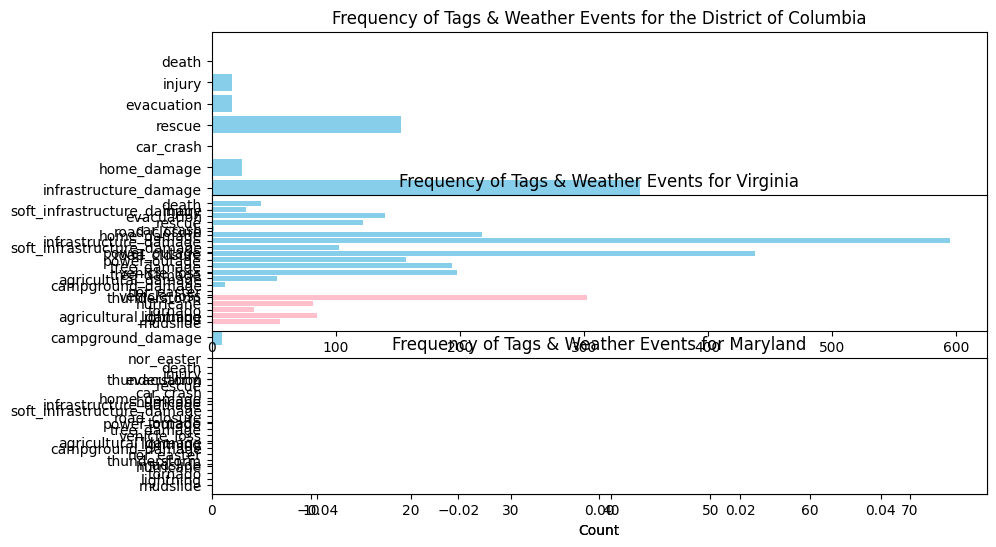

In [25]:
# FREQUENCY MAPPING FOR DC
plt.subplot(3,1,1)
plt.figure(figsize=(10, 6))
dc_tag_counts = state_label_frequency("DISTRICT OF COLUMBIA", tag_names)
dc_weather_counts = state_label_frequency("DISTRICT OF COLUMBIA", weather_names)
plt.barh(weather_names, dc_weather_counts, color="pink")
plt.barh(tag_names, dc_tag_counts, color="skyblue")
plt.title("Frequency of Tags & Weather Events for the District of Columbia")
plt.xlabel("Count")
# FREQUENCY MAPPING FOR VIRGINIA
plt.subplot(3,1,2)
va_tag_counts = state_label_frequency("VIRGINIA", tag_names)
va_weather_counts = state_label_frequency("VIRGINIA", weather_names)
plt.barh(weather_names, va_weather_counts, color="pink")
plt.barh(tag_names, va_tag_counts, color="skyblue")
plt.title("Frequency of Tags & Weather Events for Virginia")
plt.xlabel("Count")
# FREQUENCY MAPPING FOR MARYLAND
plt.subplot(3,1,3)
md_tag_counts = state_label_frequency("MARYLAND", tag_names)
md_weather_counts = state_label_frequency("MARYLAND", weather_names)
plt.barh(weather_names, md_weather_counts, color="pink")
plt.barh(tag_names, md_tag_counts, color="skyblue")
plt.title("Frequency of Tags & Weather Events for Maryland")
plt.xlabel("Count")

Text(0.5, 0, 'Count')

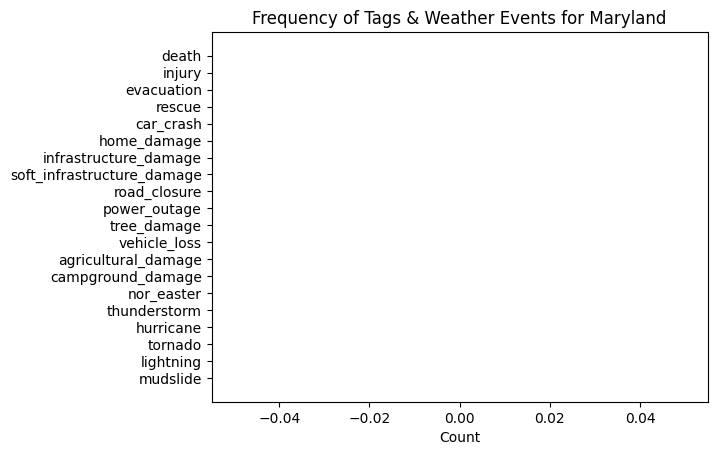

In [26]:
# FREQUENCY MAPPING FOR MARYLAND
md_tag_counts = state_label_frequency("MARYLAND", tag_names)
md_weather_counts = state_label_frequency("MARYLAND", weather_names)
plt.barh(weather_names, md_weather_counts, color="pink")
plt.barh(tag_names, md_tag_counts, color="skyblue")
plt.title("Frequency of Tags & Weather Events for Maryland")
plt.xlabel("Count")

Text(0.5, 0, 'Count')

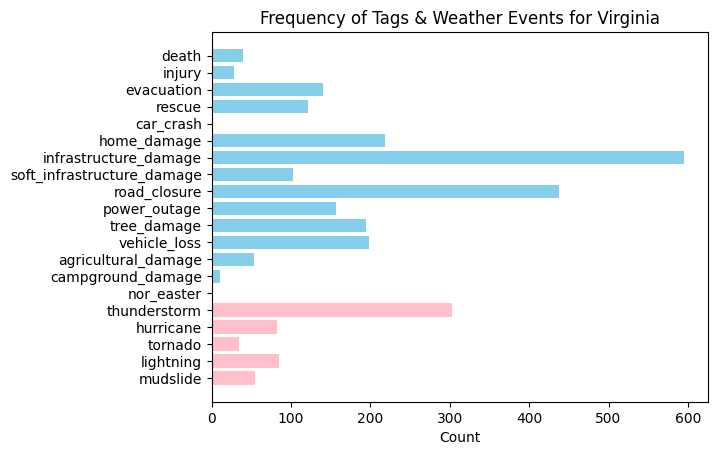

In [27]:
# FREQUENCY MAPPING FOR VIRGINIA
va_tag_counts = state_label_frequency("VIRGINIA", tag_names)
va_weather_counts = state_label_frequency("VIRGINIA", weather_names)
plt.barh(weather_names, va_weather_counts, color="pink")
plt.barh(tag_names, va_tag_counts, color="skyblue")
plt.title("Frequency of Tags & Weather Events for Virginia")
plt.xlabel("Count")

### Correlation Heatmaps

#### Impact vs. Impact

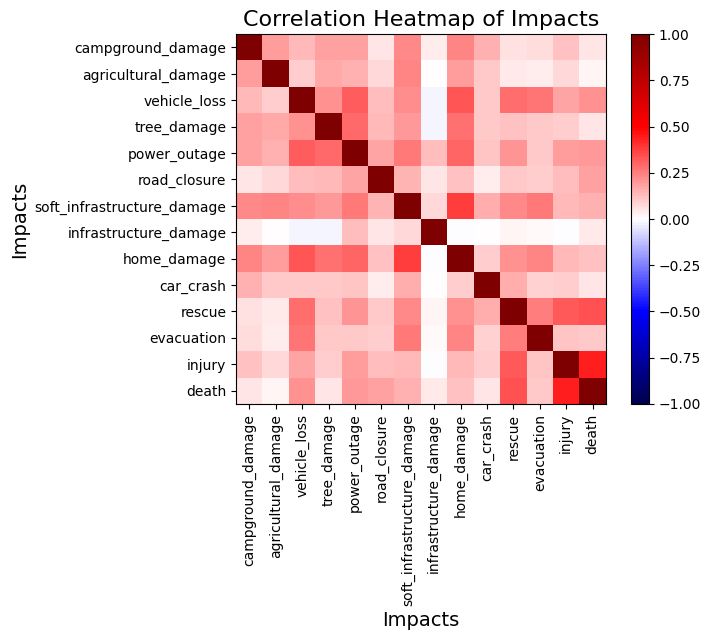

<Figure size 1000x800 with 0 Axes>

In [28]:
#heat map of the tags
all_tags = tag_names + weather_names


import seaborn as sns

# Compute correlation matrix for tag columns
corr_matrix = df2[tag_names].corr()

#heatmap of tags with tags
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix, cmap='seismic', vmin=-1, vmax=1)  # Changed 'rocket' to 'RdBu'
# Add color bar
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(range(len(tag_names)), labels=tag_names, rotation=90,fontsize=10)  # Rotate x-axis labels for better visibility
ax.set_yticks(range(len(tag_names)), labels=tag_names, rotation=0,fontsize=10)  # Set y-axis labels
plt.figure(figsize=(10, 8))  # Adjust figure size for better visibility
# Set title and labels
ax.set_title('Correlation Heatmap of Impacts', fontsize=16)
ax.set_xlabel('Impacts', fontsize=14)
ax.set_ylabel('Impacts', fontsize=14)
# Overlay seaborn heatmap for annotation and better visuals
#sns.heatmap(corr_matrix, cmap='Spectral', annot=True, vmin=-1, vmax=1, linewidths=0.5, linecolor='white', ax=ax)
plt.show()

#### Weather Events vs. Impact

C:\Users\jessi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\jessi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


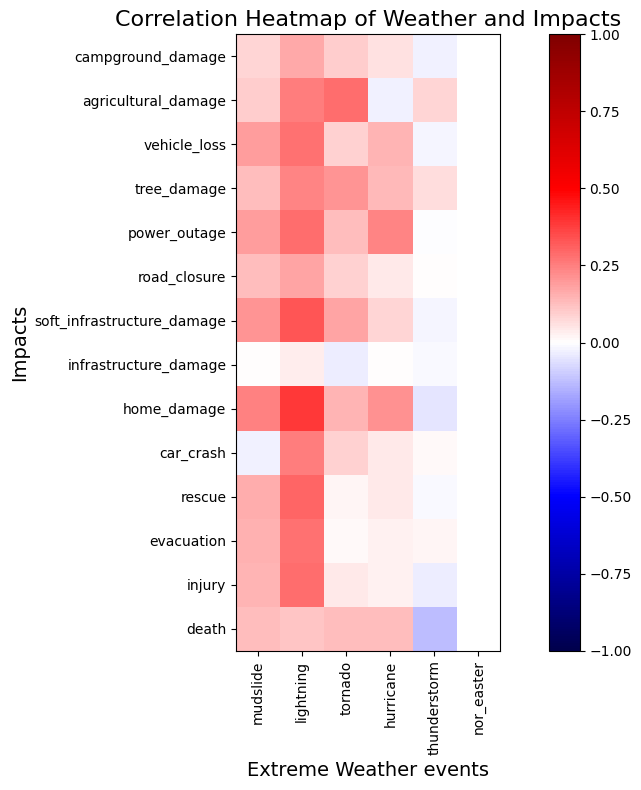

In [29]:
#heatmap of tags with weather events
import numpy as np

# Compute correlations between tag columns and weather columns
corr_matrix_weather = np.corrcoef(df2[tag_names].T, df2[weather_names].T)
# Extract submatrix (tags × weather)
n_tags = len(tag_names)
n_weather = len(weather_names)
corr_submatrix = corr_matrix_weather[:n_tags, n_tags:]  # shape: (tags, weather)

fig, ax = plt.subplots(figsize=(10, 8))  # Proper figsize set on the same figure
im = ax.imshow(corr_submatrix, cmap='seismic', vmin=-1, vmax=1)

# Colorbar
cbar = fig.colorbar(im, ax=ax)

# Set tick labels
ax.set_xticks(range(len(weather_names)))
ax.set_xticklabels(weather_names, rotation=90, fontsize=10)

ax.set_yticks(range(len(tag_names)))
ax.set_yticklabels(tag_names, rotation=0, fontsize=10)

# Titles
ax.set_title('Correlation Heatmap of Weather and Impacts', fontsize=16)
ax.set_xlabel('Extreme Weather events', fontsize=14)
ax.set_ylabel('Impacts', fontsize=14)

plt.tight_layout()
plt.show()

<a id = "sec6"></a>
## **Create FIS score - Danielle** 
We should check for multicollinearity 
on a scale of 0% to 100% --> 0 to 1

In [30]:
weights = {
    'death': 1.0,
    'injury': 0.9,
    'evacuation': 0.8,
    'rescue': 0.8,
    'car_crash': 0.5,
    'home_damage': 0.7,
    'infrastructure_damage': 0.7,
    'soft_infrastructure_damage': 0.6,
    'road_closure': 0.4,
    'power_outage': 0.6,
    'tree_damage': 0.4,
    'vehicle_loss': 0.2,
    'agricultural_damage': 0.4,
    'campground_damage': 0.3,
    'animal_loss': 0.2
}
def FIS_score(tag):
    for key, value in weights.items():
        if key in tag:
            return value
# Calculate FIS score by summing weights for each tag present (value==1) in each row
df2['FIS_score'] = df2.apply(lambda row: sum(weights[tag] for tag in tag_names if tag in row and row[tag] == 1), axis=1)
# Display the first few rows of the DataFrame with the FIS score
df2[['FIS_score'] + tag_names].head()

,FIS_score,campground_damage,agricultural_damage,vehicle_loss,tree_damage,power_outage,road_closure,soft_infrastructure_damage,infrastructure_damage,home_damage,car_crash,rescue,evacuation,injury,death
0,2.1,0,0,1,0,1,0,1,0,1,0,0,0,0,0
1,0.8,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,1.7,0,0,1,1,0,1,0,0,1,0,0,0,0,0
3,1.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
4,0.8,0,0,0,1,0,1,0,0,0,0,0,0,0,0
